1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [2]:
# Necssary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
#import pydotplus 
#import pydot
import graphviz
%matplotlib inline
%matplotlib inline
import random

df =pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv',index_col=0)


df['default'] = df['default'].replace('No','Default_No').replace('Yes','Default_Yes')
df['student'] = df['student'].replace('No','Student_No').replace('Yes','Student_Yes')
df.head()

,default,student,balance,income
1,Default_No,Student_No,729.526495,44361.625074
2,Default_No,Student_Yes,817.180407,12106.134700
3,Default_No,Student_No,1073.549164,31767.138947
4,Default_No,Student_No,529.250605,35704.493935
5,Default_No,Student_No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [3]:
df_default=pd.get_dummies(df['default'])
df_student=pd.get_dummies(df['student'])
df_final = pd.concat([df[['balance','income']],df_default,df_student],axis=1)
# df_final = pd.concat([df.drop(['default', 'student'], axis=1), df_default, 
#                    df_student], axis=1)
df_final = df_final.drop(['Default_No', 'Student_No'], axis=1)
df_final.head()

,balance,income,Default_Yes,Student_Yes
1,729.526495,44361.625074,0,0
2,817.180407,12106.134700,0,1
3,1073.549164,31767.138947,0,0
4,529.250605,35704.493935,0,0
5,785.655883,38463.495879,0,0


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

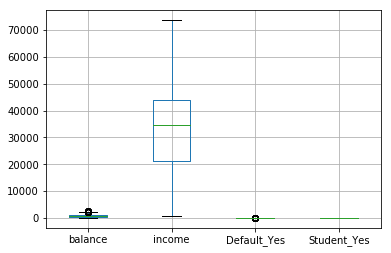

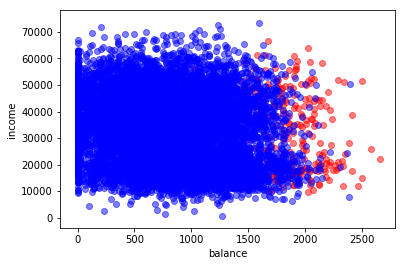

In [4]:
df_final.boxplot()
plt.show()

df_y = df_final[df_final.Default_Yes==1]
df_n = df_final[df_final.Default_Yes==0]
#plt.figure(figsize=(10, 10))
plt.scatter(x=df_y['balance'], y=df_y['income'], c='r', label='Default_yes', alpha=0.5)
plt.scatter(x=df_n['balance'], y=df_n['income'], c='b', label='Default_no', alpha=0.5)
plt.xlabel('balance')
plt.ylabel('income')
#plt.legend(prop={'size':15})
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

Area under the ROC curve : 0.942457


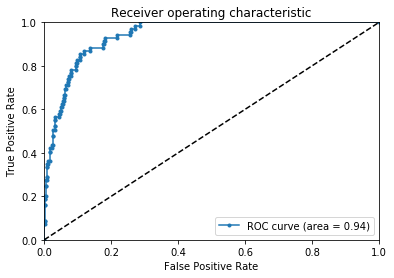

In [5]:
X = df_final[['balance', 'income']]
y = df_final.Default_Yes

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print "Area under the ROC curve : %f" % roc_auc
    return fpr, tpr, roc_auc, thresholds, classifier

def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Generate ROC  for LR with l1 penalty and C=0.1
fpr, tpr, roc_auc, thresholds, clf = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
# print clf.intercept_
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

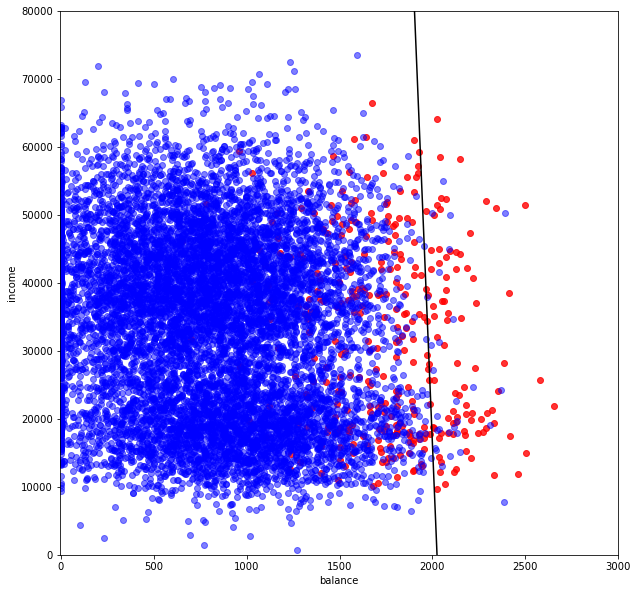

In [6]:
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(0, 3000)
yy = a * xx - (clf.intercept_[0]) / w[1]

f, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x=df_y['balance'], y=df_y['income'], c='r', label='default_yes', alpha=0.8)
ax.scatter(x=df_n['balance'], y=df_n['income'], c='b', label='default_no', alpha=0.5)
#ax.plot(dt, (-w0-w1*dt)/w2, 'k')
ax.plot(xx, yy, 'k-')
ax.set(xlim=(-5, 3000), ylim=(0, 80000),
       xlabel="balance", ylabel="income")
plt.show()

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

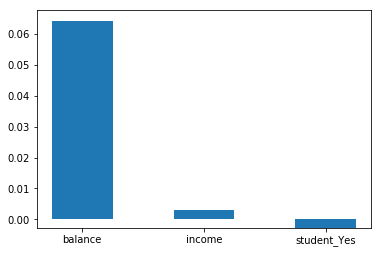

In [15]:
X = df_final[['balance', 'income','Student_Yes']]
y = df_final.Default_Yes
scaler = StandardScaler()
X = X.as_matrix().astype(np.float)
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create linear regression object
alphas = np.logspace(-8, -3,30)
scores = []

for alpha in alphas:
    regr = Lasso(alpha=alpha)

    # Train the model using the training sets
    regr.fit(X_train, y_train)
    scores.append(regr.score(X_test,y_test))
# plt.plot(alphas,scores)
# plt.show()
opt_index = np.array(scores).argmax()

regr = Ridge(alpha=alphas[opt_index])
regr.fit(X_train, y_train)
# ind = np.arange(3)  
# width = 0.50

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(3), regr.coef_, 0.5)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('balance', 'income', 'student_Yes'))
rects = ax.patches


**Comment:**

Based on the bar plot above, we see that if he/she is a student, it has negative coefficient and thus it is likely to default. 

**Using Logistic Regression**

Area under the ROC curve : 0.943935


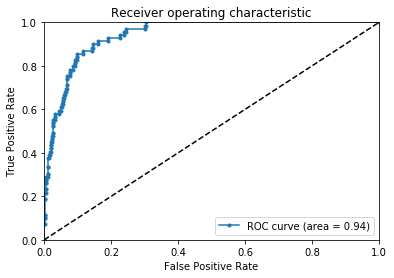

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
fpr, tpr, roc_auc, thresholds, clf = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
generate_ROCplot(fpr,tpr,'LR',roc_auc)

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

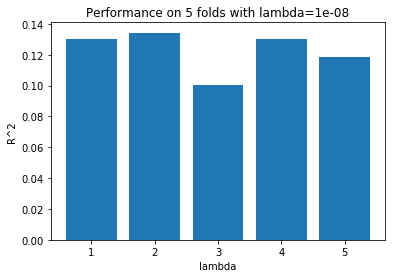

In [22]:
from sklearn.model_selection import cross_val_score

regr = Ridge(alpha=alphas[opt_index])
scores = cross_val_score(regr, X, y, cv=5)
plt.xlabel('lambda')
plt.ylabel('R^2')
plt.title('Performance on 5 folds with lambda=' + str(alphas[opt_index]))
plt.bar(range(1,6),scores)
plt.show()

Area under the ROC curve : 0.943935


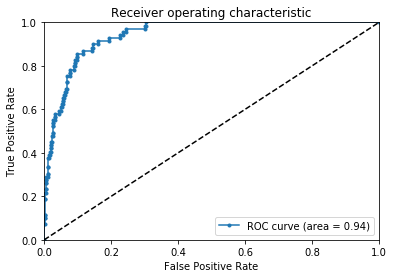

Area under the ROC curve : 0.943838


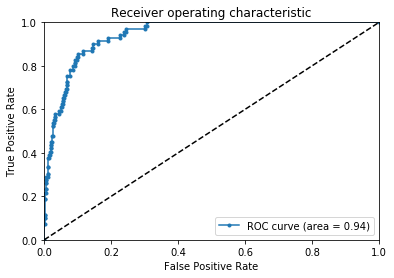

Area under the ROC curve : 0.944003


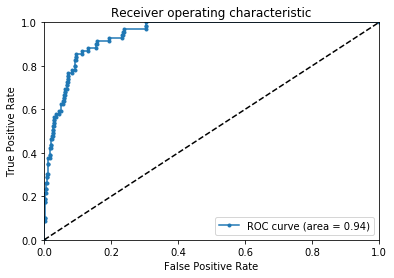

Area under the ROC curve : 0.943905


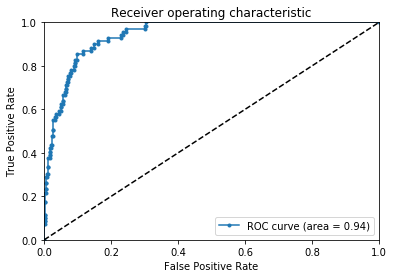

In [18]:
X = df_final[['balance', 'income','Student_Yes']]
y = df_final.Default_Yes
rand = [0, 30, 40, 100]

for r in rand:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)
#     clf = LogisticRegression(penalty='l1', C=0.1)
#     clf.fit(X_train, y_train)
#     plot_roc(clf, X_test, y_test, 'under random_state = %s' %s)
    fpr, tpr, roc_auc, thresholds, clf = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
    generate_ROCplot(fpr,tpr,'LR',roc_auc)

**Comment:**

Here we ran different state of random case and we obtain a simimar result and corss validation prove that our result is robust!

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

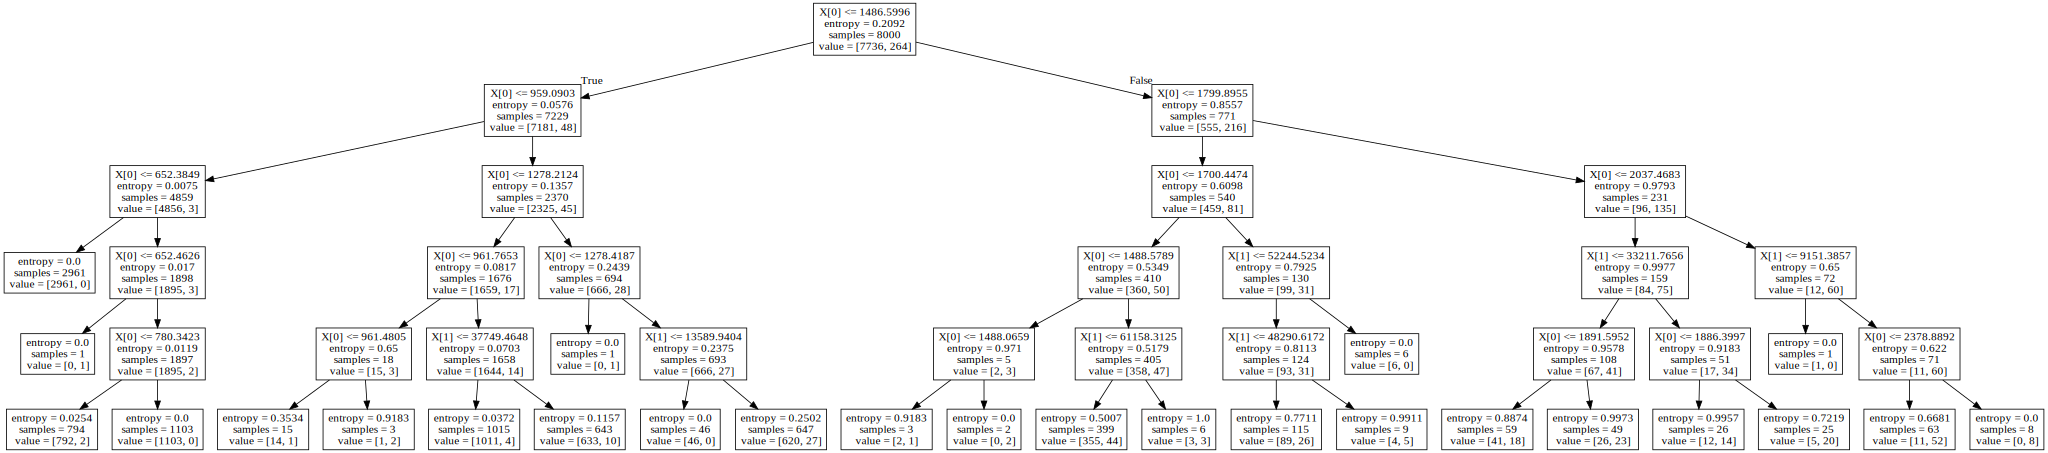

In [72]:
X = df_final[['balance', 'income','Student_Yes']]
y = df_final.Default_Yes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg_tree = DecisionTreeClassifier(criterion='entropy',  max_depth=5)
reg_tree.fit(X_train, y_train)

dot_data=export_graphviz(reg_tree, out_file='Reg_Tree.dot')
with open("Reg_Tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph, format='png')

8) Find the optimal decision tree depth and compute the AUC ROC. 

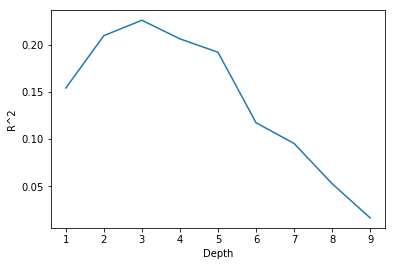

The optimal decision tree depth is 3


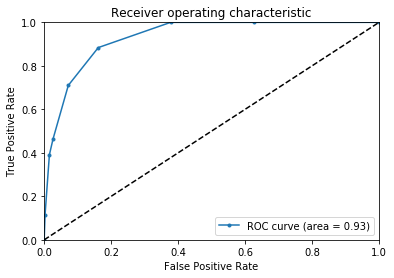

In [24]:
# Fit regression model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,10)
for n in depths:
    regr = DecisionTreeRegressor(max_depth=n)
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
    
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
plt.show()
test_errors=scores
n_opt=depths[np.argmax(scores)]
print "The optimal decision tree depth is %d" %n_opt

reg_opt = DecisionTreeClassifier(criterion='entropy', max_depth= n_opt)
reg_opt.fit(X_train,y_train)
probas_ = reg_opt.predict_proba(X_test)    
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr,tpr)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

